# Jar Targetting System
## Training Program
Liam Akkerman, Aidan Hunter

In [1]:
# load libraries

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [13]:
# load the dataset

from glob import glob
import bz2
import pickle

dataset = list()

# loads every archive of the dataset
archive_list = glob('../dataset/*.pkl.bz2')
for archive in archive_list:
    with bz2.BZ2File(archive, mode='r') as f:
        dataset.extend(pickle.load(f))

In [14]:
# Split the data

x_data = np.asarray([a['image']/255.0 for a in dataset if not a['testing']], dtype='float')

y_data_raw = [a['label'] for a in dataset if not a['testing']]
y_data_coord = np.asarray(y_data_raw, dtype='object')

y_data_image = np.zeros((*x_data.shape[:3], 1), dtype='float')
for i, pt_list in enumerate(y_data_raw): # TODO rewrite with better looping
    for pt in pt_list:
        y_data_image[i, int(np.floor(pt[0])), int(np.floor(pt[1])), :] = 0.99 #TODO keras says this must be below 1 for some reason

print('loaded', len(x_data), 'datapoints')

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data_image, test_size=0.2, shuffle=True)

print('training:', len(x_train), 'pts,\t testing:', len(x_test), 'pts')
print('X is shape', x_train.shape, '\tof type', type(x_train))
print('Y is shape', y_train.shape, '\tof type', type(y_train))


# clear the memeroy beacuse this is big
# dataset = None 
# x_data = None
# y_data = None

loaded 170 datapoints
training: 136 pts,	 testing: 34 pts
X is shape (136, 500, 500, 3) 	of type <class 'numpy.ndarray'>
Y is shape (136, 500, 500, 1) 	of type <class 'numpy.ndarray'>


<class 'tuple'>


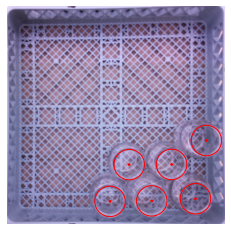

In [15]:
# visualize samples
from random import choice
import matplotlib.patches as patches

rand_image = choice(list(zip(x_data, y_data_coord)))
print(type(rand_image))
while len(rand_image[1]) < 5:    # make sure the chosen one is interesting
    rand_image = choice(list(zip(x_train, y_train)))

fig, ax = plt.subplots()
plt.imshow(rand_image[0]) # TODO this broke
plt.xlim([0, 500])
plt.ylim([0, 500])
plt.axis('off')

for point in rand_image[1]:
    outline_marker = patches.Circle(point, radius=35, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(outline_marker)
    centre_marker = patches.Circle(point, radius=2, color='r')
    ax.add_patch(centre_marker)

In [5]:
# define the model layers
# TODO currently this is just the 4th CNN from assigment 3

model = keras.Sequential([
    keras.layers.Input(shape=x_data[0].shape),
    keras.layers.Conv2D(filters=1, kernel_size=3, activation='relu', padding='same'),
])

In [16]:
# train and evalute the model

model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

hist = model.fit(x=x_train, y=y_train, epochs=3)
loss, acc = model.evaluate(x=x_test, y=y_test)

print('test accuracy:', acc)
print('test loss:', loss)

Epoch 1/3
5/5 [==============================] - 7s 820ms/step - loss: 0.0000e+00 - accuracy: 0.9967
Epoch 2/3
5/5 [==============================] - 4s 760ms/step - loss: 0.0000e+00 - accuracy: 0.9967
Epoch 3/3
2/2 [==============================] - 1s 30ms/step - loss: 0.0000e+00 - accuracy: 0.9967
test accuracy: 0.9967212677001953
test loss: 0.0


In [23]:
rand_image = choice(list(zip(x_test, y_test)))

print(rand_image[0].shape)
print(rand_image[1].shape)

plt.figure()
plt.imshow(rand_image[0])

test_result = model.predict(rand_image[0])
plt.figure()
plt.plot(rand_image[1])

(500, 500, 1)


ValueError: in user code:

    C:\Users\liam\.conda\envs\ml_course\lib\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    C:\Users\liam\.conda\envs\ml_course\lib\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\liam\.conda\envs\ml_course\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\liam\.conda\envs\ml_course\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\liam\.conda\envs\ml_course\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\liam\.conda\envs\ml_course\lib\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    C:\Users\liam\.conda\envs\ml_course\lib\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    C:\Users\liam\.conda\envs\ml_course\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\liam\.conda\envs\ml_course\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:239 assert_input_compatibility
        str(tuple(shape)))

    ValueError: Input 0 of layer sequential is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: (None, 500, 3)


In [ ]:
# convert and save model

from datetime import datetime

# format is YYYYMMDDHHmm
filename = 'model-' + datetime.now().strftime('%Y%m%d%H%M') + '.tflite'
print('writing', filename)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open(filename, 'wb') as f:
    f.write(tflite_model)